In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_mr = path/'small-256'
path_lr = path/'small-96'

In [3]:
il = ImageImageList.from_folder(path_hr)

In [4]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [5]:
sets = [(path_lr,96), (path_mr,256)]
for p,size in sets:
    if not p.exists():
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [6]:
bs, size = 32, 128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [7]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
            .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c=3
    return data

In [8]:
data = get_data(bs,size)

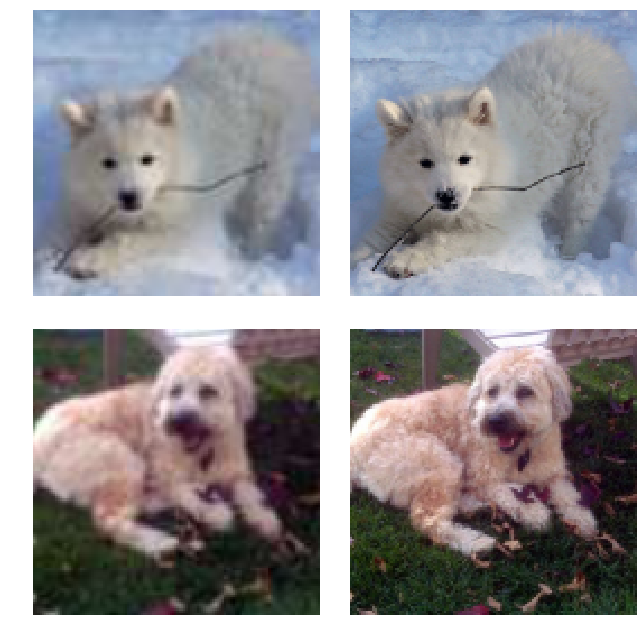

In [9]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [10]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [11]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return(x @ x.transpose(1,2))/(c*h*w)

In [12]:
gram_matrix(t)

tensor([[[0.1162, 0.1210, 0.1290],
         [0.1210, 0.1266, 0.1358],
         [0.1290, 0.1358, 0.1468]],

        [[0.1162, 0.1210, 0.1290],
         [0.1210, 0.1266, 0.1358],
         [0.1290, 0.1358, 0.1468]]])

In [13]:
base_loss = F.l1_loss 

In [14]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /tmp/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:06<00:00, 81350045.65it/s]


In [15]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o, nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [16]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]
        
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input, target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                            for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                            for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [17]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,12,2])

In [18]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 28912382.38it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


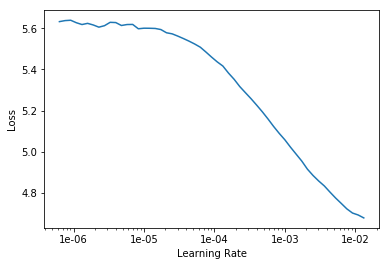

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
lr = 1e-3/2

In [21]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.412475,3.297771,0.150595,0.232926,0.254869,0.226638,0.577947,0.784125,1.070672,01:51
1,3.300827,3.168386,0.145706,0.228776,0.248245,0.218985,0.537045,0.753067,1.036562,01:47
2,3.216310,3.096151,0.148091,0.226570,0.242651,0.214167,0.519638,0.732242,1.012793,01:48
3,3.183334,3.030652,0.146612,0.224217,0.239803,0.208155,0.507979,0.721644,0.982242,01:47
4,3.103143,2.968061,0.145902,0.223850,0.235773,0.203959,0.490810,0.702405,0.965362,01:47
5,3.077968,2.933892,0.147195,0.223788,0.234266,0.201434,0.478377,0.694669,0.954162,01:47
6,3.045337,2.890726,0.143256,0.219984,0.230944,0.198312,0.473340,0.686106,0.938785,01:46
7,3.005600,2.858225,0.151017,0.218500,0.228072,0.195156,0.464232,0.674408,0.926842,01:47
8,2.971487,2.850859,0.140329,0.218502,0.227307,0.194536,0.469223,0.677732,0.923230,01:47
9,2.880620,2.737253,0.137300,0.215081,0.221981,0.187846,0.432132,0.652016,0.890898,01:47


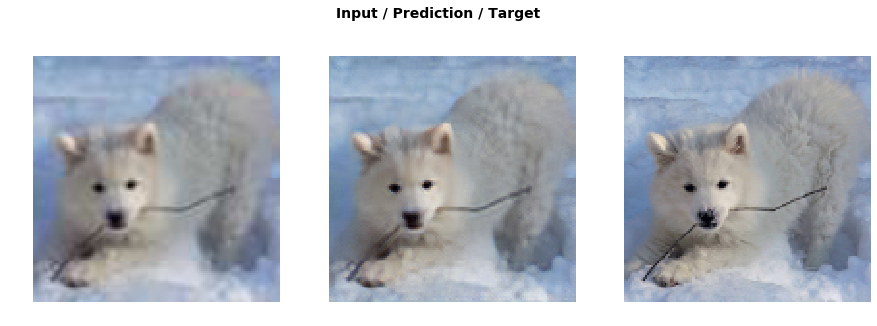

In [22]:
do_fit('1a', slice(lr*10))

In [23]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.869965,2.729059,0.137712,0.215159,0.221859,0.187500,0.427414,0.650224,0.889190,01:47
1,2.847767,2.722502,0.137532,0.214808,0.221422,0.186902,0.426940,0.648707,0.886191,01:47
2,2.849848,2.718567,0.137030,0.214469,0.220897,0.186520,0.426192,0.647809,0.885650,01:47
3,2.872354,2.709775,0.136946,0.214423,0.220629,0.186060,0.423459,0.645999,0.882260,01:47
4,2.847168,2.711403,0.136963,0.213883,0.219910,0.185990,0.424989,0.645715,0.883952,01:47
5,2.837072,2.703784,0.136855,0.213844,0.219924,0.185725,0.421255,0.644105,0.882077,01:46
6,2.836231,2.700094,0.138196,0.214196,0.220129,0.185401,0.418032,0.644565,0.879576,01:46
7,2.845822,2.700586,0.137421,0.214345,0.219857,0.185207,0.421806,0.643848,0.878102,01:47
8,2.828972,2.689465,0.136758,0.213105,0.218692,0.184563,0.417581,0.640375,0.878391,01:46
9,2.818563,2.676120,0.136870,0.212903,0.218442,0.183633,0.413867,0.638479,0.871925,01:47


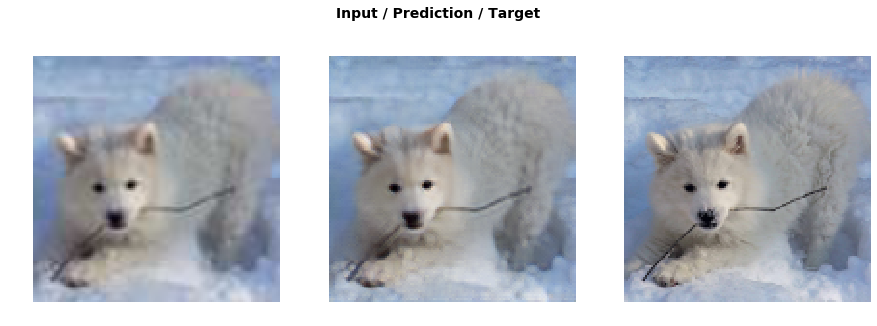

In [24]:
do_fit('1b', slice(1e-5,lr))

In [25]:
data = get_data(12, size*2)

In [26]:
learn.data = data
learn.freeze()
gc.collect()

19038

In [27]:
learn.load('1b')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /tmp/.fastai/data/oxford-iiit-pet/small-96;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /tmp/.fastai/data/oxford-iiit-pet/small-96;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1

In [28]:
do_fit('2a')

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.955415,1.940331,0.164785,0.259900,0.236467,0.154954,0.384212,0.372699,0.367313,04:50
1,1.924756,1.917885,0.165619,0.259241,0.235043,0.153438,0.373092,0.368295,0.363157,04:34
2,1.921105,1.895856,0.165854,0.260220,0.234177,0.153039,0.360030,0.362215,0.360321,04:34
3,1.889205,1.890939,0.167112,0.259221,0.233032,0.151588,0.360954,0.361431,0.357600,04:34
4,1.877445,1.870055,0.166500,0.259087,0.232273,0.151171,0.347599,0.357252,0.356172,04:34


In [29]:
learn.unfreeze()

In [30]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.814357,1.821646,0.166748,0.256525,0.226879,0.146647,0.331103,0.347684,0.346059,04:43
1,1.819428,1.819727,0.167179,0.256541,0.226779,0.146604,0.330365,0.346837,0.345423,04:43
2,1.806534,1.817938,0.166958,0.255941,0.226407,0.145892,0.330880,0.347332,0.344530,04:43
3,1.795817,1.813924,0.166198,0.256314,0.226140,0.145775,0.328895,0.346660,0.343943,04:43
4,1.805982,1.810280,0.166627,0.256056,0.225744,0.145400,0.327877,0.345348,0.343230,04:44
5,1.798314,1.808622,0.167106,0.255857,0.225674,0.145440,0.326737,0.344903,0.342907,04:44


In [31]:
learn = None
gc.collect()

11808

In [32]:
free = gpu_mem_get_free_no_cache()
if free > 8000: size=(1280,1600)
else:           size=(820,1024)
print(f"using size={size}, have {free}MB of GPU RAM free ")

using size=(1280, 1600), have 13857MB of GPU RAM free 


In [33]:
learn = unet_learner(data, arch, loss_func=feat_loss, blur=True, norm_type=NormType.Weight)

In [34]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x:path_mr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c=3

In [35]:
learn.load('2b')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /tmp/.fastai/data/oxford-iiit-pet/small-96;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /tmp/.fastai/data/oxford-iiit-pet/small-96;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1

In [36]:
learn.data = data_mr

In [37]:
fn = data_mr.valid_ds.x.items[0]; fn

PosixPath('/tmp/.fastai/data/oxford-iiit-pet/small-256/samoyed_14.jpg')

In [38]:
img = open_image(fn)
img.shape

torch.Size([3, 256, 358])

In [39]:
p,img_hr,b = learn.predict(img)

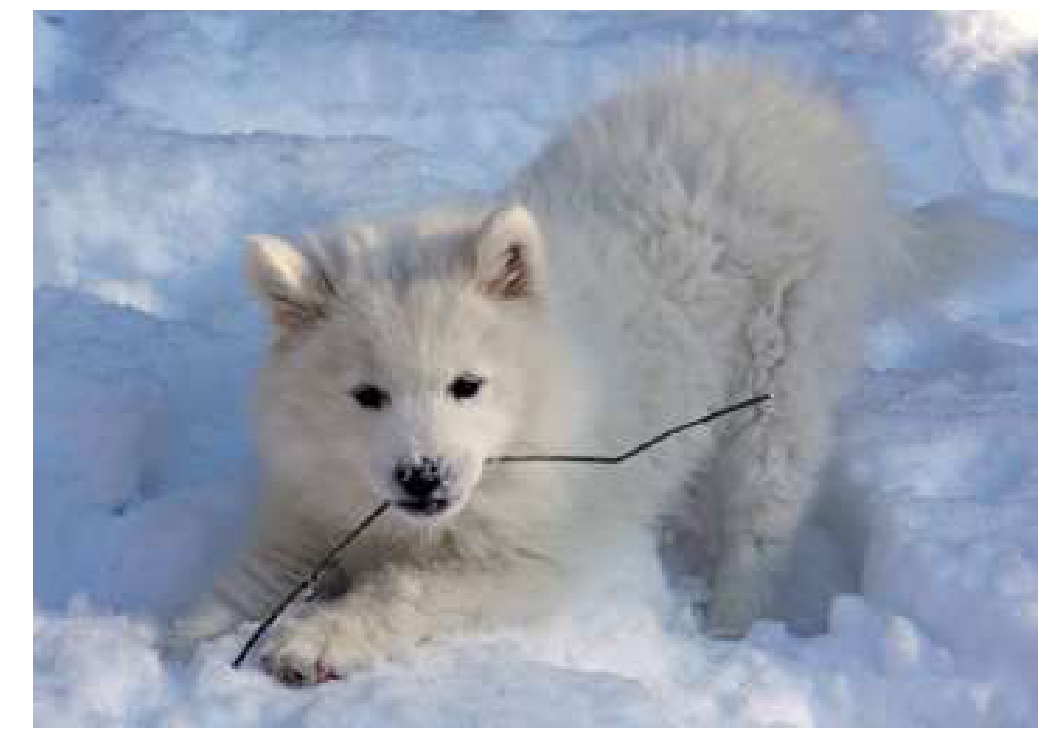

In [40]:
show_image(img, figsize=(18,15), interpolation='nearest')

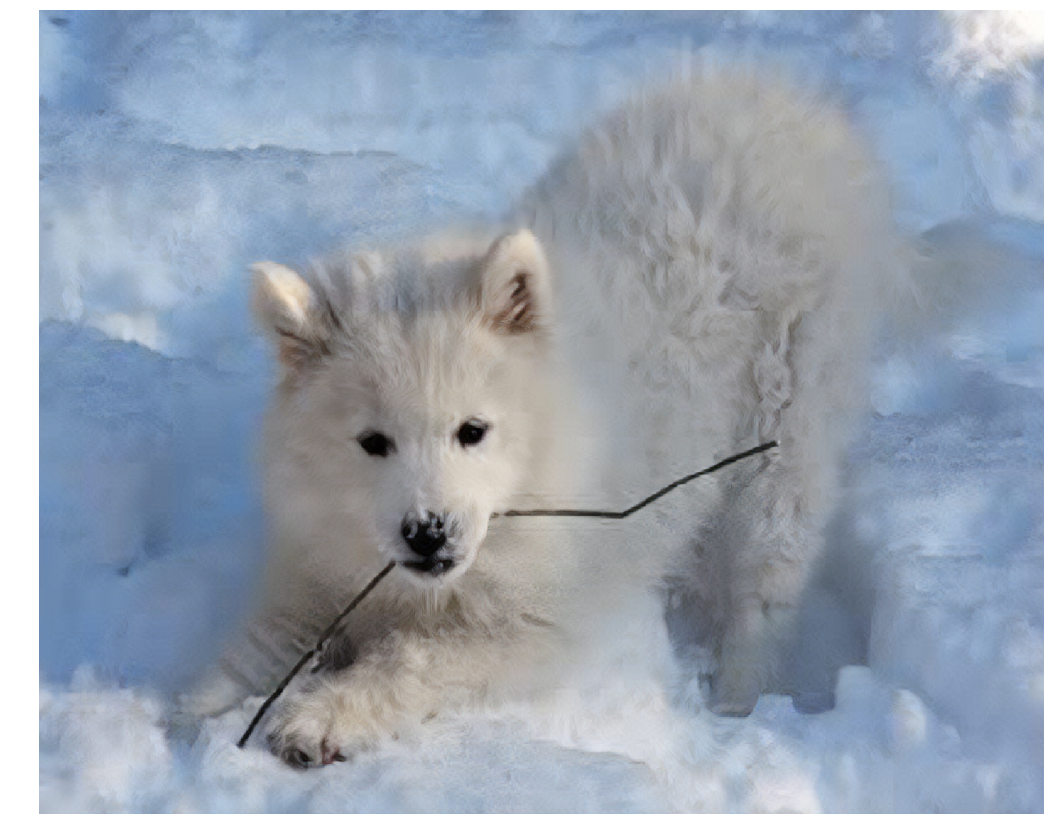

In [41]:
Image(img_hr).show(figsize=(18,15))